In [88]:
import cProfile
import matplotlib.pyplot as plt
import numba
import numpy as np
import pyfftw
from pyfftw.interfaces.numpy_fft import fftshift
from pyfftw.interfaces.numpy_fft import ifftshift
from pyfftw.interfaces.numpy_fft import rfftn
from pyfftw.interfaces.numpy_fft import irfftn
from pyfftw.interfaces.numpy_fft import rfft2
from pyfftw.interfaces.numpy_fft import irfft2
import scipy as sp
import scipy.ndimage as ndi
import seaborn as sns

from pyem import mrc
from pyem.util import *
from pyem.vop import *
from pyem.ctf import eval_ctf as eval_ctf_lib

%matplotlib inline
sns.set()
pyfftw.interfaces.cache.enable()

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [162]:
def CTF(N, def1, def2, angast, ps, kv, ac, cs, bf=0, lp=0, phaseshift=0):
    """
    N = pixels of CTF image
    def1/2 = prinicipal defocus values in angstroms (underfocus positive)
    angast = angle from x-axis to azimuth of astigmatism in degrees 
    ps = image pixelsize in angstroms
    kv = acceleration voltage in kilovolts
    ac = amplitude contrast fraction (0-->1)
    cs = spherical aberration in millimeters
    bf = B-factor, divided by 4 in exponential. (negative = lowpass)
    lp = hard low-pass filter, given in angstroms
    """

    kv = kv * 1E3
    cs = cs * 1E7
    a_o = np.deg2rad(angast)
    lamb = 12.2639 / np.sqrt(kv * (1. + kv * .978466E-6))

    def_avg = -(def1 + def2) * 0.5
    def_dev = -(def1 - def2) * 0.5

    # Constants
    K1 = np.pi / 2. * 2 * lamb
    K2 = np.pi / 2. * cs * lamb**3
    K3 = np.sqrt(1 - ac**2)
    K4 = bf / 4.  # B-factor, follows RELION convention
    K5 = np.deg2rad(phaseshift)  # Phase shift

    nyq = 1. / (2. * ps)
    x, y = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
    rho = np.sqrt(x**2 + y**2)
    a = np.arctan2(y, x)
    s = (rho * nyq)

    if lp != 0:
        s[s > (1 / float(lp))] = 0

    s_2 = s**2
    s_4 = s**4

    dZ = def_avg + def_dev * (np.cos(2 * (a - a_o)))
    gamma = (K1 * dZ * s_2) + (K2 * s_4) - K5
    CTF = -(K3 * np.sin(gamma) - ac*np.cos(gamma))

    if bf != 0:
        CTF *= np.exp(-K4 * s_2)

    return CTF, dZ, gamma

In [15]:
ctf20k_n = lambda x: CTF(x, 20000, 20000, 0, 2.0, 200, 0.1, 2.0, 0, 0)
ctf = CTF(256, 20000, 20000, 0, 2.0, 200, 0.1, 2.0, 0, 0)

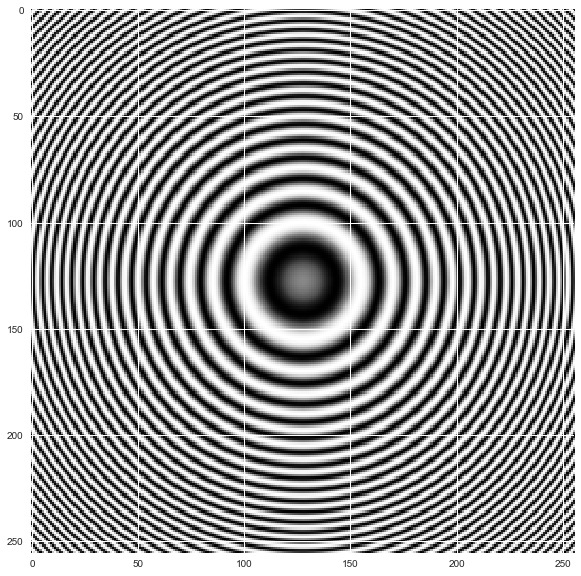

In [42]:
f, ax = plt.subplots(figsize=(10,10))
ax.imshow(ctf)

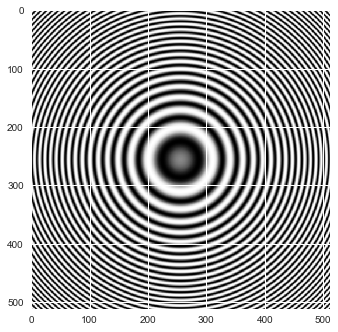

In [43]:
plt.imshow(ctf20k_n(512))

(75, 125)

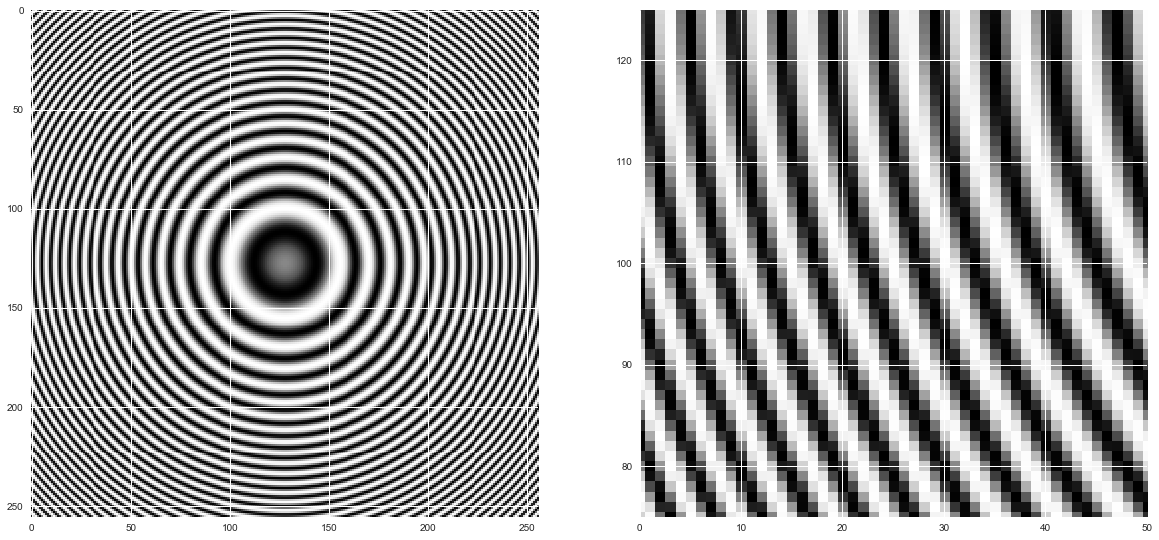

In [11]:
f, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(ctf)
ax[1].imshow(ctf)
ax[1].set_xlim((0,50))
ax[1].set_ylim((75, 125))

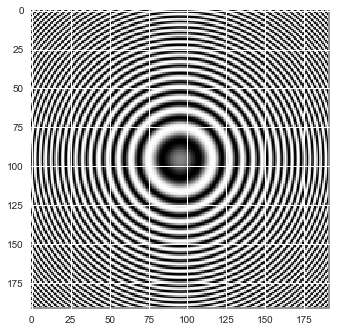

In [38]:
aaf = 10
plt.imshow(ndi.zoom(ndi.zoom(ctf20k_n(192), aaf, order=3), 1./aaf, order=3))

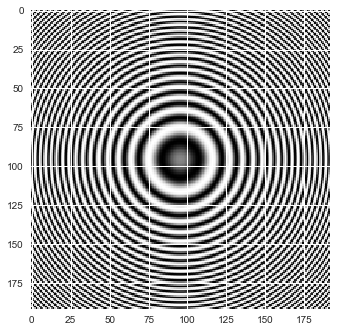

In [39]:
aaf = 1.0
plt.imshow(ndi.zoom(ndi.zoom(ctf20k_n(192), aaf, order=3), 1./aaf, order=3))

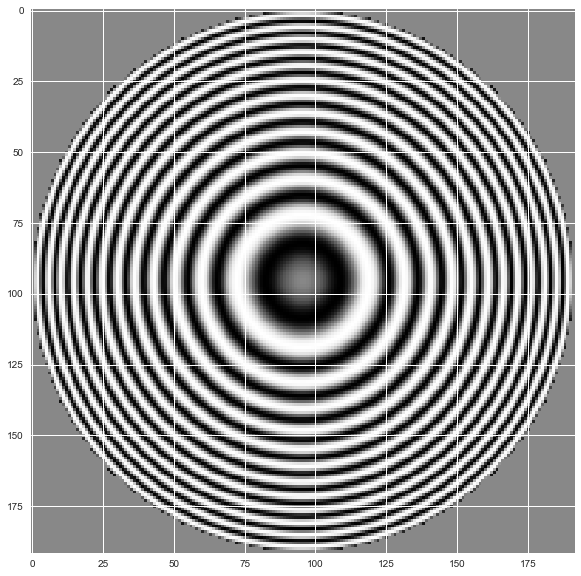

In [187]:
ctf, dZ, gamma = CTF(192, 20000, 20000, 0, 2.0, 300, 0.1, 2.0, bf=0, lp=4.0)
f, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(ndi.zoom(ctf, 1))
# ax.set_xlim(96,288)
# ax.set_ylim(96,288)

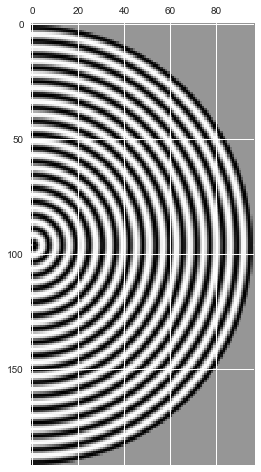

In [217]:
plt.matshow(np.sin(fftshift(s, axes=0) * 256))

In [189]:
np.min(gamma)

-76.34302640852854

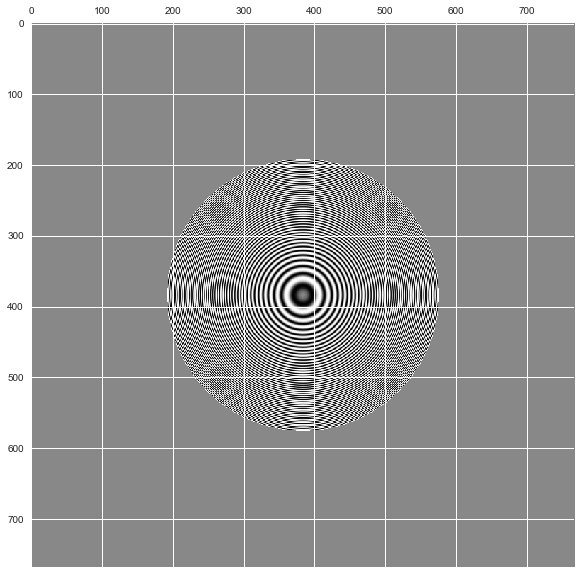

In [201]:
ctf, _, _ = CTF(4 * 192, 20000, 20000, 0, 0.5, 300, 0.1, 2.0, bf=0, lp=2.0)
f, ax = plt.subplots(1, figsize=(10,10))
ax.matshow(ctf)

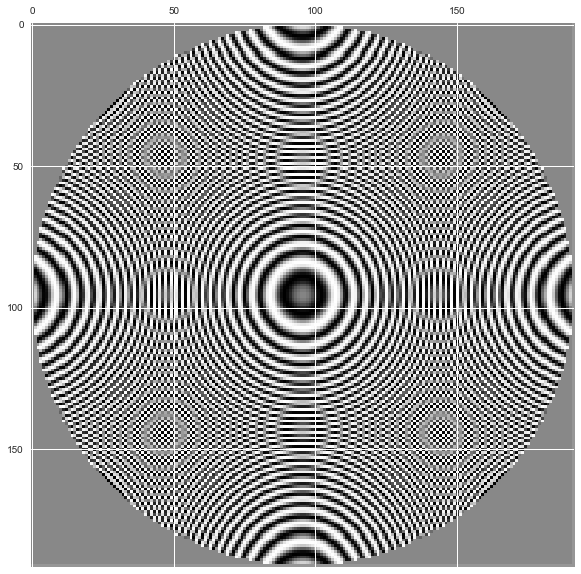

In [150]:
ctf = CTF(192 * 10, 20000, 20000, 0, 1.0, 300, 0.1, 2.0, bf=0, lp=2.0)
ctf = ndi.zoom(ctf, 1./10, order=0)
f, ax = plt.subplots(1, figsize=(10,10))
ax.matshow(ctf)

In [114]:
def ctf_freqs(shape, apix=1.0, full=True):
    d = 1. / apix
    if full:
        xfrq = np.fft.fftfreq(shape[1])
    else:
        xfrq = np.fft.rfftfreq(shape[1])
    x, y = np.meshgrid(xfrq, np.fft.fftfreq(shape[0]))
    rho = np.sqrt(x**2 + y**2)
    a = np.arctan2(y, x)
    s = rho * d
    return s, a


# @numba.vectorize(nopython=True)
# def eval_ctf(s, a, def1, def2, angast, phase, kv, ac, cs, bf, lp):
@numba.jit(cache=True, nopython=True)
def eval_ctf(s, a, def1, def2, angast=0, phase=0, kv=300, ac=0.1, cs=2.0, bf=0, lp=0):
    """
    :param s: Precomputed frequency grid for CTF evaluation.
    :param a: Precomputed frequency grid angles.
    :param def1: 1st prinicipal underfocus distance (A).
    :param def2: 2nd principal underfocus distance (A).
    :param angast: Angle of astigmatism (deg) from x-axis to azimuth.
    :param phase: Phase shift (deg).
    :param kv:  Microscope acceleration potential (kV).
    :param ac:  Amplitude contrast in [0, 1.0].
    :param cs:  Spherical aberration (mm).
    :param bf:  B-factor, divided by 4 in exponential, lowpass positive.
    :param lp:  Hard low-pass filter (A).
    """
    angast = np.deg2rad(angast)
    kv = kv * 1E3
    cs = cs * 1E7
    
    lamb = 12.2639 / np.sqrt(kv * (1. + kv * 0.978466E-6))

    def_avg = -(def1 + def2) * 0.5
    def_dev = -(def1 - def2) * 0.5

    # Constants
    k1 = np.pi / 2. * 2 * lamb
    k2 = np.pi / 2. * cs * lamb**3
    k3 = np.sqrt(1 - ac**2)
    k4 = bf / 4.  # B-factor, follows RELION convention.
    k5 = np.deg2rad(phase)  # Phase shift.

    if lp != 0:
        s *= s <= (1. / lp)

    s_2 = s**2
    s_4 = s_2**2

    dZ = def_avg + def_dev * (np.cos(2 * (a - angast)))
    gamma = (k1 * dZ * s_2) + (k2 * s_4) - k5
    ctf = -(k3 * np.sin(gamma) - ac * np.cos(gamma))

    if bf != 0:
        ctf *= np.exp(-k4 * s_2)

    return ctf

In [115]:
rfrq = np.fft.rfftfreq(192)
cfrq = np.fft.fftfreq(192)
sx, sy, = np.meshgrid(rfrq, cfrq)
rho = np.sqrt(sx**2 + sy**2)
ang = np.arctan2(sy, sx)

In [120]:
rho * (1 / 1.234)

array([[0.        , 0.00422069, 0.00844138, ..., 0.396745  , 0.40096569,
        0.40518639],
       [0.00422069, 0.00596896, 0.00943775, ..., 0.39676745, 0.40098791,
        0.40520837],
       [0.00844138, 0.00943775, 0.01193792, ..., 0.39683479, 0.40105454,
        0.40527431],
       ...,
       [0.01266207, 0.013347  , 0.01521792, ..., 0.39694701, 0.40116557,
        0.40538418],
       [0.00844138, 0.00943775, 0.01193792, ..., 0.39683479, 0.40105454,
        0.40527431],
       [0.00422069, 0.00596896, 0.00943775, ..., 0.39676745, 0.40098791,
        0.40520837]])

In [135]:
s, a = ctf_freqs((192,192), apix=1.234, full=False)
c = eval_ctf(s, a, 20000, 20000, angast=0, phase=0, kv=300, ac=0.1, cs=2.0, bf=0, lp=2.468)
clib = eval_ctf_lib(s, a, 20000, 20000, angast=0, phase=0, kv=300, ac=0.1, cs=2.0, bf=0, lp=2.468)
# c = eval_ctf(s, a, 20000, 20000, 0, 0, 300, 0.1, 2.0, 0, 0)

In [118]:
s

array([[0.40518639, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.4009436 , 0.40096581, 0.40103245, ..., 0.        , 0.        ,
        0.        ],
       [0.39670081, 0.39672326, 0.39679061, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.39670081, 0.39672326, 0.39679061, ..., 0.        , 0.        ,
        0.        ],
       [0.4009436 , 0.40096581, 0.40103245, ..., 0.        , 0.        ,
        0.        ],
       [0.40518639, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [90]:
np.array_equal(clib, c)

True

In [31]:
%timeit s, a = ctf_freqs((192,192), ps=1.234)

1000 loops, best of 3: 1.06 ms per loop


In [61]:
%lprun -f eval_ctf eval_ctf(s, a, 20000, 20000, 0, 2.0, 300, 0.1, 2.0, bf=0, lp=0)

In [134]:
%timeit eval_ctf(s, a, 20000, 20000, 0, 1.234, 300, 0.1, 2.0, 0, 2.468)

The slowest run took 3221.60 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 538 µs per loop


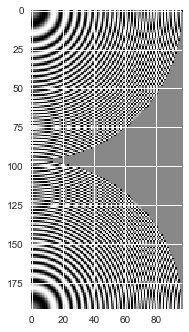

In [136]:
f, ax = plt.subplots(1)
ax.imshow(c)

In [73]:
for v, k in eval_ctf.inspect_asm().items():
    print v, k

(array(float64, 2d, C), array(float64, 2d, C), int64, int64, int64, float64, int64, float64, float64, int64, int64) 	.section	__TEXT,__text,regular,pure_instructions
	.macosx_version_min 10, 12
	.section	__TEXT,__literal8,8byte_literals
	.p2align	3
LCPI0_0:
	.quad	4652007308841189376
LCPI0_1:
	.quad	4517227501668264522
LCPI0_2:
	.quad	4607182418800017408
LCPI0_3:
	.quad	4580687790476533049
LCPI0_4:
	.quad	4711630319722168320
LCPI0_5:
	.quad	4623093579988522028
LCPI0_6:
	.quad	4614256656552045848
LCPI0_7:
	.quad	4602678819172646912
LCPI0_8:
	.quad	4609753056924675352
LCPI0_9:
	.quad	4598175219545276416
LCPI0_13:
	.quad	-9223372036854775808
	.section	__TEXT,__literal4,4byte_literals
	.p2align	2
LCPI0_10:
	.long	1
	.section	__TEXT,__literal16,16byte_literals
	.p2align	4
LCPI0_11:
	.byte	0
	.byte	4
	.byte	8
	.byte	12
	.space	1
	.space	1
	.space	1
	.space	1
	.space	1
	.space	1
	.space	1
	.space	1
	.space	1
	.space	1
	.space	1
	.space	1
LCPI0_12:
	.quad	-9223372036854775808
	.quad	-922337203